# Daily Price Data

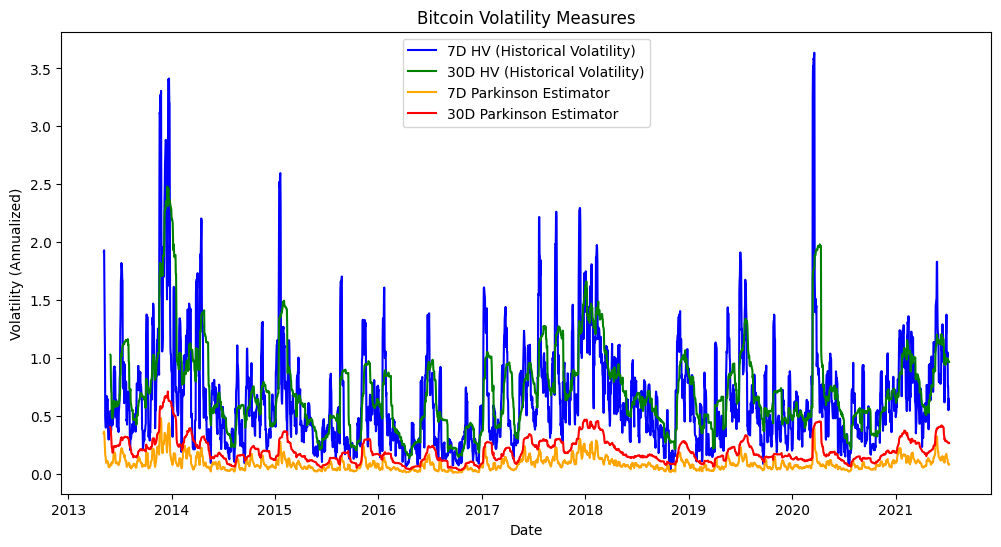

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths for datasets
file_paths = {
    "Bitcoin": "../../data/raw/daily/coin_Bitcoin.csv",
    "Ethereum": "../../data/raw/daily/coin_Ethereum.csv",
    "XRP": "../../data/raw/daily/coin_XRP.csv",
    "Dogecoin": "../../data/raw/daily/coin_Dogecoin.csv"
}

def calculate_hv(data, window):
    """
    Calculate Historical Volatility (HV) using log returns over a rolling window.
    
    Parameters:
    - data: DataFrame with 'Close' price column.
    - window: Rolling window size for HV (e.g., 7 or 30 days).
    
    Returns:
    - Series containing the HV values.
    """
    log_return = np.log(data['Close'] / data['Close'].shift(1))
    hv = log_return.rolling(window=window).std() * np.sqrt(365)  # Annualized HV
    return hv

# Function to calculate Parkinson Volatility
def calculate_parkinson(data, window):
    """
    Calculate Parkinson Volatility using high and low prices over a rolling window.
    
    Parameters:
    - data: DataFrame with 'High' and 'Low' columns.
    - window: Rolling window size for Parkinson Volatility (e.g., 7 or 30 days).
    
    Returns:
    - Series containing Parkinson Volatility values.
    """
    parkinson_vol = np.sqrt(
        (1 / (4 * np.log(2))) *
        (np.log(data['High'] / data['Low']) ** 2).rolling(window=window).sum()
    )
    return parkinson_vol

# Function to process a single dataset
def process_volatility(file_path, window_sizes=[7, 30]):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values(by='Date', inplace=True)
    data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))

    # Calculate HV and Parkinson Volatility for each window size
    for window in window_sizes:
        data[f'{window}D HV'] = calculate_hv(data, window)
        data[f'{window}D Parkinson'] = calculate_parkinson(data, window)
    return data

results = {}
for name, path in file_paths.items():
    results[name] = process_volatility(path)

save_paths = {
    "Bitcoin": "../../data/processed/daily/coin_Bitcoin_processed.csv",
    "Ethereum": "../../data/processed/daily/coin_Ethereum_processed.csv",
    "XRP": "../../data/processed/daily/coin_XRP_processed.csv",
    "Dogecoin": "../../data/processed/daily/coin_Dogecoin_processed.csv"
}
for name, data in results.items():
    data.to_csv(save_paths[name], index=False)

def plot_volatility(data, asset_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['7D HV'], label="7D HV (Historical Volatility)", color='blue')
    plt.plot(data['Date'], data['30D HV'], label="30D HV (Historical Volatility)", color='green')
    plt.plot(data['Date'], data['7D Parkinson'], label="7D Parkinson Estimator", color='orange')
    plt.plot(data['Date'], data['30D Parkinson'], label="30D Parkinson Estimator", color='red')
    plt.title(f"{asset_name} Volatility Measures")
    plt.xlabel("Date")
    plt.ylabel("Volatility (Annualized)")
    plt.legend()
    plt.show()

plot_volatility(results['Bitcoin'], "Bitcoin")

# Minute Data
- Hourly RV
- Daily RV
- Daily squared returns (from close)

In [21]:
import pandas as pd
import numpy as np

# Load the BTC/USD dataset
file_paths = {
    "Bitcoin": "../../data/raw/minute/btcusd.csv",
    "Algorand": "../../data/raw/minute/algusd.csv",
    "Ethereum": "../../data/raw/minute/ethusd.csv",
    "Dogecoin": "../../data/raw/minute/dogusd.csv"
}

save_paths = {
    "Bitcoin": "../../data/processed/minute/btcusd.csv",
    "Algorand": "../../data/processed/minute/algusd.csv",
    "Ethereum": "../../data/processed/minute/ethusd.csv",
    "Dogecoin": "../../data/processed/minute/dogusd.csv"
}

file_path = "../../data/raw/minute/btcusd.csv"
data = pd.read_csv(file_path)

# Convert Unix Timestamp (milliseconds) to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')
data.set_index('time', inplace=True)
data.sort_index(inplace=True)

# Calculate intraday returns (log returns)
data['Log Return'] = np.log(data['close'] / data['close'].shift(1))
# Remove rows with NaN returns (due to the shift operation)
data.dropna(subset=['Log Return'], inplace=True)

# Calculate realized variance
rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))
rv_1d = data.resample('1D')['Log Return'].apply(lambda x: np.sum(x**2))

# Daily Squared Returns (proxy for daily variance)
def safe_daily_squared_return(x):
    if len(x) > 1:
        return (np.log(x.iloc[-1] / x.iloc[0]))**2
    else:
        return np.nan  # Handle cases where the group is empty or incomplete

daily_squared_returns = data.resample('1D')['close'].apply(safe_daily_squared_return)

rv_results = pd.DataFrame({
    '15min RV': rv_15min,
    '1H RV': rv_1h,
    '1D RV': rv_1d,
    'Daily Squared Returns': daily_squared_returns
})

data_with_rv = data.merge(rv_results, how='left', left_on='time', right_on='time')
# results.to_csv("processed_btcusd.csv", index=False)

# Display results
print(results.head())

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/3363703202.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/3363703202.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))


   level_0  index       time  Daily RV  Hourly RV  Daily Squared Returns
0        0      0 2013-04-01  0.020519   0.020519               0.001538
1        1      1 2013-04-02  0.010789   0.010789               0.016444
2        2      2 2013-04-03  0.253974   0.253974               0.017614
3        3      3 2013-04-04  0.041282   0.041282               0.000181
4        4      4 2013-04-05  0.010508   0.010508               0.008034


In [22]:
import pandas as pd
import numpy as np

# Function to calculate log returns
def calculate_log_returns(data):
    """
    Calculate log returns for the 'close' prices in the dataset.
    """
    data['Log Return'] = np.log(data['close'] / data['close'].shift(1))
    data.dropna(subset=['Log Return'], inplace=True)
    return data

# Function to calculate realized variance
def calculate_realized_variance(data):
    """
    Calculate realized variance (RV) for 15-minute, 1-hour, and 1-day intervals.
    """
    rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
    rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))
    rv_1d = data.resample('1D')['Log Return'].apply(lambda x: np.sum(x**2))
    return rv_15min, rv_1h, rv_1d

# Function to calculate daily squared returns
def calculate_daily_squared_returns(data):
    """
    Calculate the daily squared returns (proxy for daily variance).
    """
    def safe_daily_squared_return(x):
        if len(x) > 1:
            return (np.log(x.iloc[-1] / x.iloc[0]))**2
        else:
            return np.nan  # Handle cases where the group is empty or incomplete

    daily_squared_returns = data.resample('1D')['close'].apply(safe_daily_squared_return)
    return daily_squared_returns

# Function to process a single file
def process_file(file_path):
    data = pd.read_csv(file_path)
    
    # Convert Unix Timestamp (milliseconds) to datetime and set as index
    data['time'] = pd.to_datetime(data['time'], unit='ms')
    data.set_index('time', inplace=True)
    data.sort_index(inplace=True)
    
    if 'Unnamed: 0' in data.columns:
        data = data.drop(columns=['Unnamed: 0'])
    data = calculate_log_returns(data)
    rv_15min, rv_1h, rv_1d = calculate_realized_variance(data)
    daily_squared_returns = calculate_daily_squared_returns(data)
    
    # Combine results into a DataFrame
    rv_results = pd.DataFrame({
        '15min RV': rv_15min,
        '1H RV': rv_1h,
        '1D RV': rv_1d,
        'Daily Squared Returns': daily_squared_returns
    })
    
    # Merge the results with the original data
    data_with_rv = data.merge(rv_results, how='left', left_index=True, right_index=True)
    
    return data_with_rv

# Function to process and save all files
def process_all_files(file_paths, save_paths):
    """
    Process all files in file_paths and save the processed results to save_paths.
    """
    for asset, file_path in file_paths.items():
        print(f"Processing {asset}...")
        
        # Process the file
        processed_data = process_file(file_path)
        
        # Save to the corresponding save path
        save_path = save_paths[asset]
        processed_data.to_csv(save_path)
        print(f"Saved processed data for {asset} to {save_path}")

# File paths
file_paths = {
    "Bitcoin": "../../data/raw/minute/btcusd.csv",
    "Algorand": "../../data/raw/minute/algusd.csv",
    "Ethereum": "../../data/raw/minute/ethusd.csv",
    "Dogecoin": "../../data/raw/minute/dogusd.csv"
}

save_paths = {
    "Bitcoin": "../../data/processed/minute/btcusd_processed.csv",
    "Algorand": "../../data/processed/minute/algusd_processed.csv",
    "Ethereum": "../../data/processed/minute/ethusd_processed.csv",
    "Dogecoin": "../../data/processed/minute/dogusd_processed.csv"
}

# Process and save all files
process_all_files(file_paths, save_paths)

Processing Bitcoin...


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))


Saved processed data for Bitcoin to ../../data/processed/minute/btcusd.csv
Processing Algorand...


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))


Saved processed data for Algorand to ../../data/processed/minute/algusd.csv
Processing Ethereum...


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))


Saved processed data for Ethereum to ../../data/processed/minute/ethusd.csv
Processing Dogecoin...


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rv_15min = data.resample('15T')['Log Return'].apply(lambda x: np.sum(x**2))
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_42713/930969000.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rv_1h = data.resample('1H')['Log Return'].apply(lambda x: np.sum(x**2))


Saved processed data for Dogecoin to ../../data/processed/minute/dogusd.csv


In [9]:
#ETH data for group project
#data is minute level, we want to resample into day data
import pandas as pd
file_path = "../../data/processed/minute/ethusd_processed.csv"
data = pd.read_csv(file_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
drop_columns = ['Log Return', '15min RV', '1H RV', 'Daily Squared Returns']
data.drop(columns=drop_columns, inplace=True)
daily_data = data.resample('1D').agg({
    'open': 'first',        # First open price of the day
    'close': 'last',        # Last close price of the day
    'high': 'max',          # Highest price of the day
    'low': 'min',           # Lowest price of the day
    'volume': 'sum',        # Total volume for the day
    '1D RV': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None  # First non-NA 1D RV value
})

# Drop any rows with NaN values (e.g., incomplete days)
daily_data.dropna(subset=['open', 'close', 'high', 'low', 'volume', '1D RV'], inplace=True)
# Calculate daily returns from the daily close price
daily_data['daily_return'] = daily_data['close'].pct_change()
#rename columns
data.rename(columns={'1D RV': 'realized_variance'}, inplace=True)
data.head()
data.to_csv("../../data/processed/minute/ethusd_group_project.csv", index=True)
